# **실습 4-4 : 간단한 GAN 모델 만들기** 

## **Import Module**

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models,layers 

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [0]:
# gdriver mount to load saved model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **DataSet**

### 라벨있는 샘플 데이타 생성

(array([[ 0.46988868,  0.79999952],
       [ 0.1688967 ,  0.71449843],
       [ 0.97277421, -0.99178103],
       [ 0.41442003,  0.92787915],
       [ 0.76134279, -0.43149623],
       [ 0.3721369 ,  0.9833281 ],
       [ 0.86841836, -0.81384135],
       [ 0.22718931,  0.87749054],
       [ 0.82694892, -0.68551608],
       [ 0.56316238,  0.46864164],
       [ 0.94184352, -0.96268112],
       [ 0.9145516 , -0.9200195 ],
       [ 0.73948732, -0.33646381],
       [ 0.42470635,  0.90872163],
       [ 0.65929411,  0.03473535],
       [ 0.7603453 , -0.42725105],
       [ 0.58702019,  0.36657508],
       [ 0.66139313,  0.02484841],
       [ 0.5711648 ,  0.4350033 ],
       [ 0.62429255,  0.19835894],
       [ 0.15770763,  0.6766326 ],
       [ 0.06199879,  0.28802366],
       [ 0.64649791,  0.09489999],
       [ 0.58791556,  0.3626462 ],
       [ 0.38883008,  0.96599751],
       [ 0.53021492,  0.59961001],
       [ 0.78351265, -0.52321887],
       [ 0.19419636,  0.79264112],
       [ 0.09678941

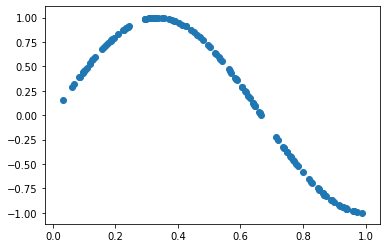

In [0]:
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [0,1]
	X1 = np.random.rand(n)
	# generate outputs sin(1.5*pi*x1) : 0~270
	X2 = np.sin(X1*np.pi*1.5)
	# stack arrays
	X1 = X1.reshape(n, 1)		#(n,1)<-(n)
	X2 = X2.reshape(n, 1)		#(n개의 1차원 vector)<-(n차원 vector) 
	X = np.hstack((X1, X2))	#(n,2)<-(n,1)(n,1)
	# generate class labels
	y = np.ones((n, 1))	#True 
	return X, y 				#((n,2),1)

# generate samples
data = generate_real_samples(128)
# plot real samples
print(data)
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show() #순서가 random인 sin 

## **GAN 모델링**

### 판별기 (discriminator)

In [0]:
# define the standalone discriminator model
'''
def define_discriminator(n_inputs=2): #target이 없음
	model = models.Sequential(name="Discriminator")
	model.add(layers.Dense(25, activation='relu', 
	            kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(layers.Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
'''
def define_discriminator(n_inputs=2): #target이 없음
	_inputs = layers.Input(n_inputs)
	x = layers.Dense(25, activation='relu', kernel_initializer='he_uniform')(_inputs)
	x = layers.Dense(1, activation='sigmoid')(x)
	model = models.Model(_inputs, x, name="Discriminator")
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

d_model=define_discriminator()
d_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### 생성기 (generator)


In [0]:
# define the standalone generator model
'''
def define_generator(latent_dim, n_outputs=2):
	model = models.Sequential(name="Generator")
	model.add(layers.Dense(15, activation='relu',
	                       kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(layers.Dense(n_outputs, activation='linear'))
	return model #loss가 없음
'''
def define_generator(latent_dim, n_outputs=2):
	in_dim = layers.Input(latent_dim) # 입력으로 들어오는 dim이 5
	x = layers.Dense(15, activation='relu', kernel_initializer='he_uniform')(in_dim)
	x = layers.Dense(n_outputs, activation='linear')(x)
	model = models.Model(in_dim, x, name="Generator")
	return model #loss가 없음

g_model=define_generator(5)
g_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


### 생성기와 판별기 결합
#### for updating the generator

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator): # target이 없음 # 이제 둘을 합쳐준다. GAN network를 만들어주는 것,
	# make weights in the discriminator not trainable 
	discriminator.trainable = False # trainable하면 안됨ㅇㅇ. 
	# connect them
	model = models.Sequential()
	# add generator
	model.add(generator) 			
	# add the discriminator
	model.add(discriminator) 	#1이면 잘 생성된것->CE작어져->Gen학습됨
	# compile model  ## 
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

gan_model=define_gan(g_model,d_model)
gan_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Model)            (None, 2)                 122       
_________________________________________________________________
Discriminator (Model)        (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


### 잠재공간에서 샘플링(생성기 입력을 위한)


In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

generate_latent_points(5,2)

array([[ 1.0282996 ,  0.75055604, -1.42333196, -1.25507883,  1.0939379 ],
       [ 1.51603043, -0.97078244, -2.33520456,  2.28699486, -0.13877118]])

### 생성기가 가짜 샘플을 생성

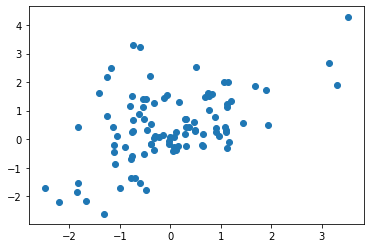

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y 				#((n,2),1)
	
# generate and plot fake samples
data = generate_fake_samples(g_model, 5, 100)
# plot fake samples
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show()

### 판별기 성능 검증 및 진짜와 가짜의 위치 시각화

Epoch:0   Acc_real:1.000000   Acc_fake:0.000000


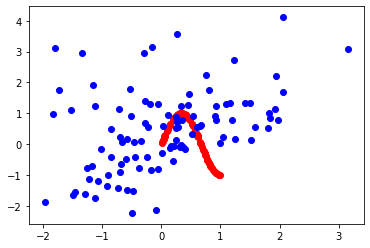

In [0]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, 
                          n=100, ovr=False):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	if ovr: 
		display.clear_output(wait=True)
	print("Epoch:%d   Acc_real:%f   Acc_fake:%f" % (epoch, acc_real, acc_fake))
	# scatter plot real and fake data points
	plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	plt.show()

summarize_performance(0,g_model,d_model,5, ovr=True)

## 생성기와 판별기 학습 및 결과

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=512, n_eval=100, override=False):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch) 
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake) 

		d_model.train_on_batch(x_real, y_real) # batch 단위로 돌린다. batch단위로 백 프로퍼게이션을 하는 것. 한번 weight 값을 업데이트한다고 생각하면 됨.
		d_model.train_on_batch(x_fake, y_fake) # discriminator와 generator가 잘 안되는 경우가 있을 수도 있음. 그러면 dis를 덜 시킨다던가 이렇게 할 수 있는 것.
		# 루프를 조정할 수 있게 된다.
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan) # 여기서는 이제 generator만 트레이닝 해주는 것,.
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim, ovr=override)

9999 0.59 0.39  
CPU times: user 10min 50s, sys: 42.4 s, total: 11min 32s  
Wall time: 10min 6s  


Epoch:99   Acc_real:0.570000   Acc_fake:0.700000


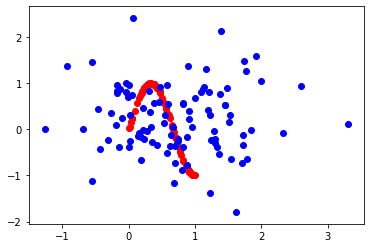

Epoch:199   Acc_real:0.870000   Acc_fake:0.350000


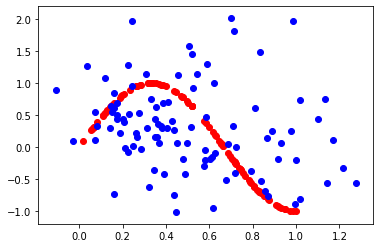

Epoch:299   Acc_real:0.720000   Acc_fake:0.500000


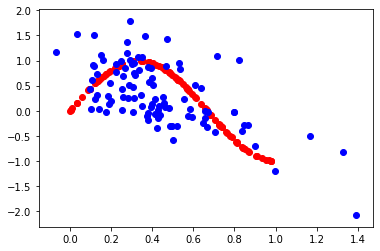

Epoch:399   Acc_real:0.570000   Acc_fake:0.580000


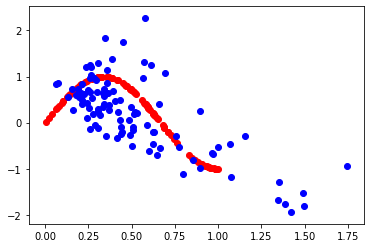

Epoch:499   Acc_real:0.610000   Acc_fake:0.660000


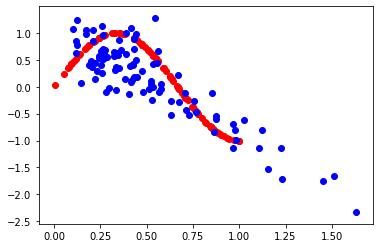

Epoch:599   Acc_real:0.690000   Acc_fake:0.600000


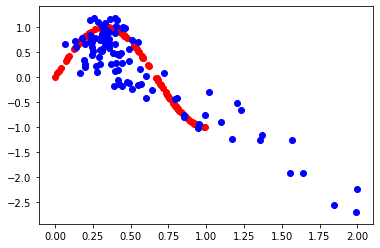

Epoch:699   Acc_real:0.590000   Acc_fake:0.740000


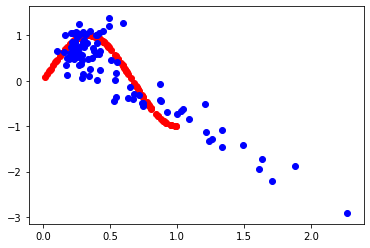

Epoch:799   Acc_real:0.410000   Acc_fake:0.760000


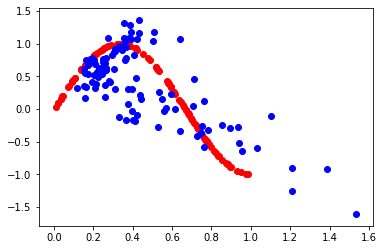

Epoch:899   Acc_real:0.290000   Acc_fake:0.710000


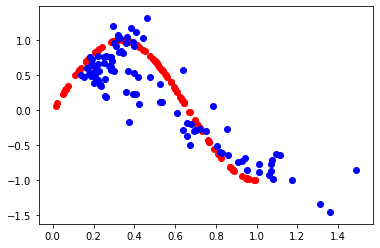

Epoch:999   Acc_real:0.370000   Acc_fake:0.820000


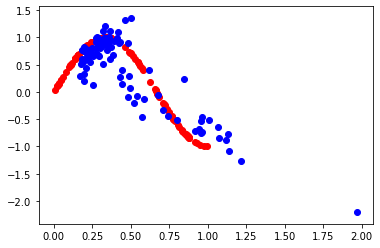

Epoch:1099   Acc_real:0.340000   Acc_fake:0.770000


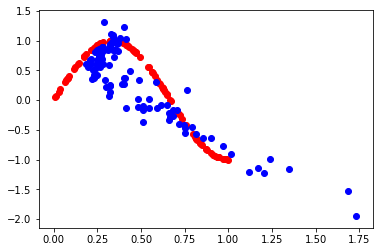

Epoch:1199   Acc_real:0.400000   Acc_fake:0.710000


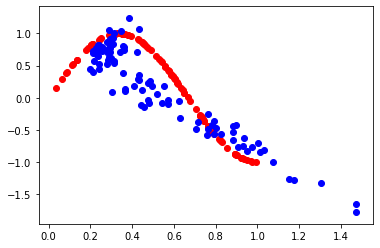

Epoch:1299   Acc_real:0.380000   Acc_fake:0.710000


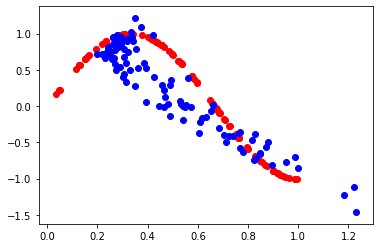

Epoch:1399   Acc_real:0.300000   Acc_fake:0.860000


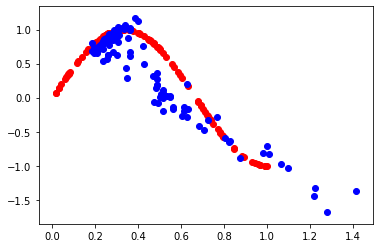

Epoch:1499   Acc_real:0.400000   Acc_fake:0.840000


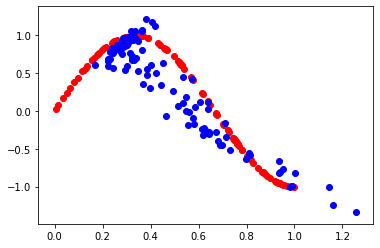

Epoch:1599   Acc_real:0.430000   Acc_fake:0.640000


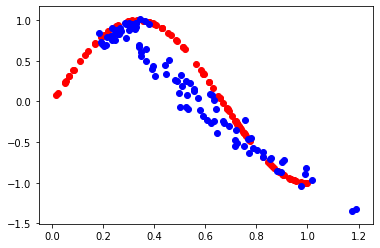

Epoch:1699   Acc_real:0.500000   Acc_fake:0.490000


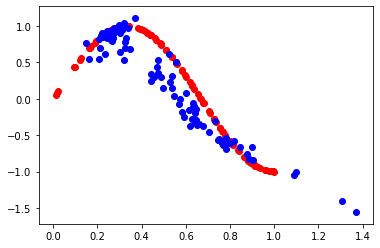

Epoch:1799   Acc_real:0.510000   Acc_fake:0.430000


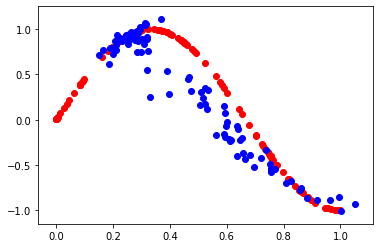

Epoch:1899   Acc_real:0.670000   Acc_fake:0.450000


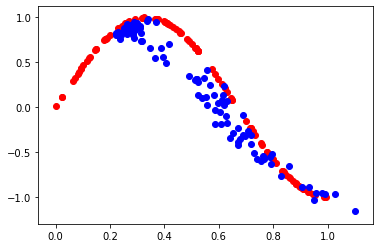

Epoch:1999   Acc_real:0.630000   Acc_fake:0.410000


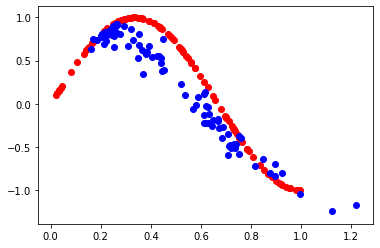

Epoch:2099   Acc_real:0.660000   Acc_fake:0.350000


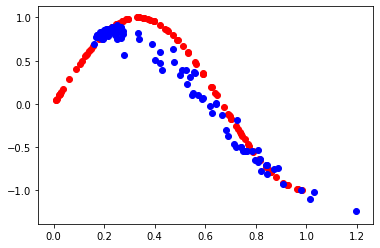

Epoch:2199   Acc_real:0.680000   Acc_fake:0.380000


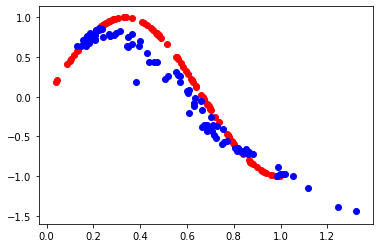

Epoch:2299   Acc_real:0.700000   Acc_fake:0.350000


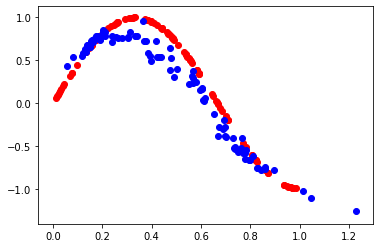

Epoch:2399   Acc_real:0.680000   Acc_fake:0.280000


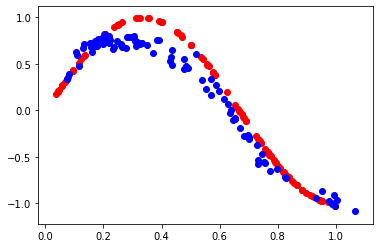

Epoch:2499   Acc_real:0.780000   Acc_fake:0.390000


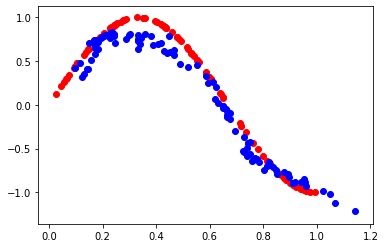

Epoch:2599   Acc_real:0.810000   Acc_fake:0.270000


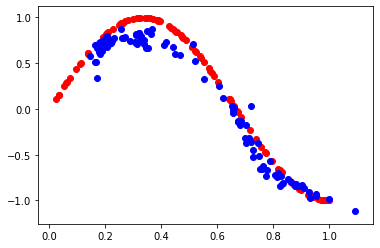

Epoch:2699   Acc_real:0.730000   Acc_fake:0.380000


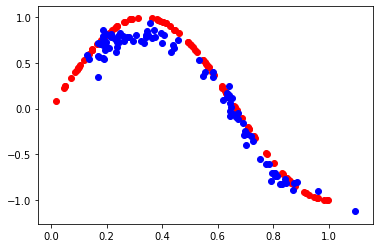

Epoch:2799   Acc_real:0.660000   Acc_fake:0.240000


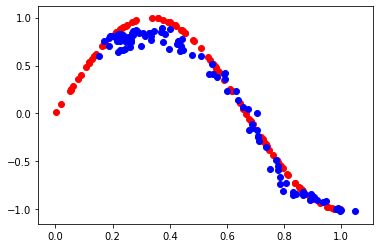

Epoch:2899   Acc_real:0.420000   Acc_fake:0.420000


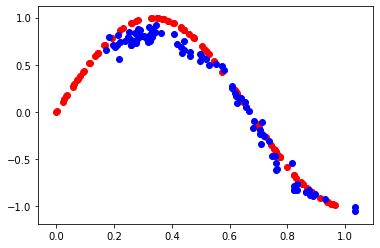

Epoch:2999   Acc_real:0.680000   Acc_fake:0.280000


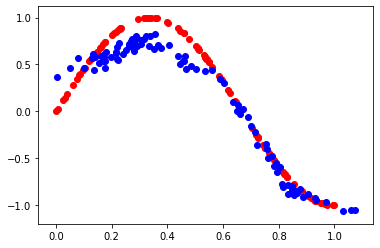

Epoch:3099   Acc_real:0.740000   Acc_fake:0.320000


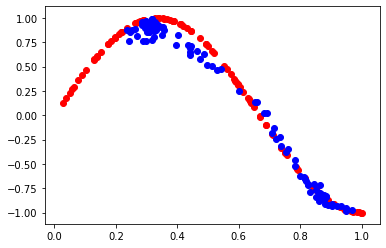

Epoch:3199   Acc_real:0.320000   Acc_fake:0.700000


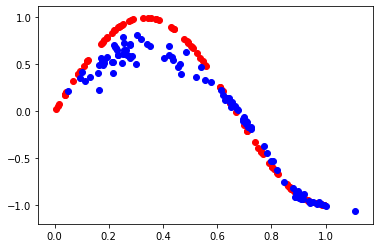

Epoch:3299   Acc_real:0.660000   Acc_fake:0.410000


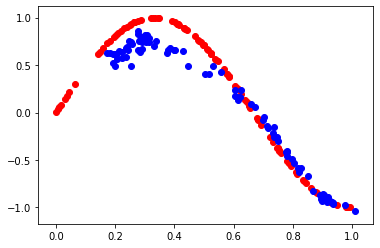

Epoch:3399   Acc_real:0.440000   Acc_fake:0.640000


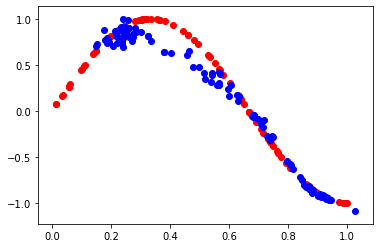

Epoch:3499   Acc_real:0.630000   Acc_fake:0.280000


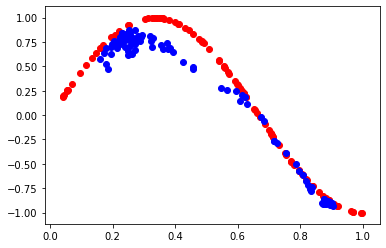

Epoch:3599   Acc_real:0.270000   Acc_fake:0.900000


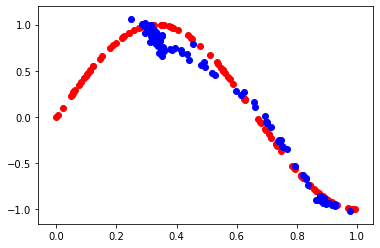

Epoch:3699   Acc_real:0.310000   Acc_fake:0.740000


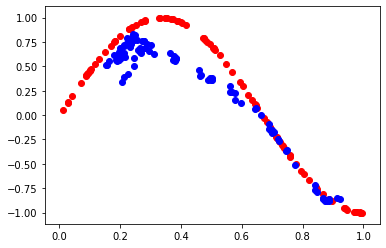

Epoch:3799   Acc_real:0.670000   Acc_fake:0.200000


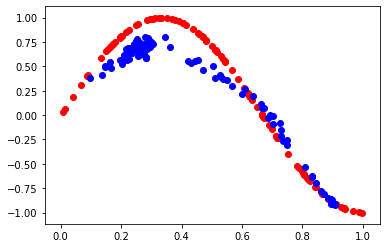

Epoch:3899   Acc_real:0.630000   Acc_fake:0.300000


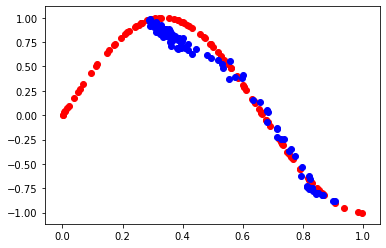

Epoch:3999   Acc_real:0.800000   Acc_fake:0.170000


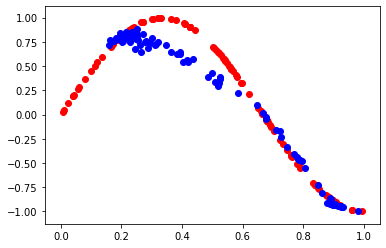

Epoch:4099   Acc_real:0.660000   Acc_fake:0.330000


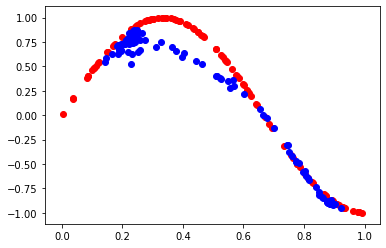

Epoch:4199   Acc_real:0.670000   Acc_fake:0.390000


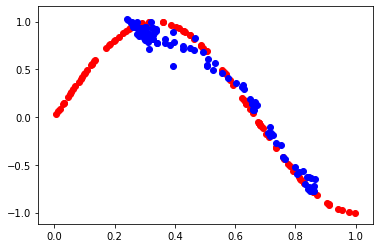

Epoch:4299   Acc_real:0.500000   Acc_fake:0.510000


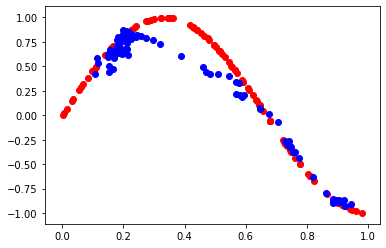

Epoch:4399   Acc_real:0.460000   Acc_fake:0.560000


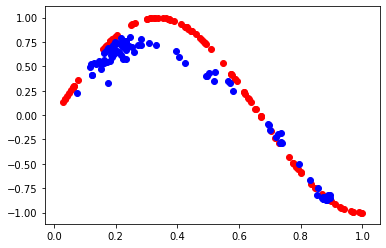

Epoch:4499   Acc_real:0.370000   Acc_fake:0.690000


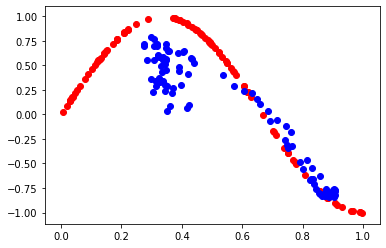

Epoch:4599   Acc_real:0.560000   Acc_fake:0.550000


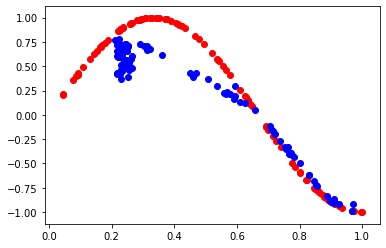

Epoch:4699   Acc_real:0.480000   Acc_fake:0.520000


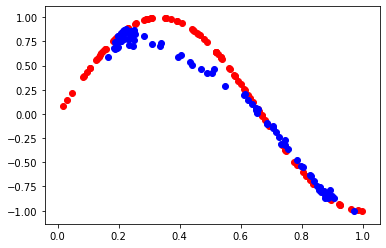

Epoch:4799   Acc_real:0.600000   Acc_fake:0.530000


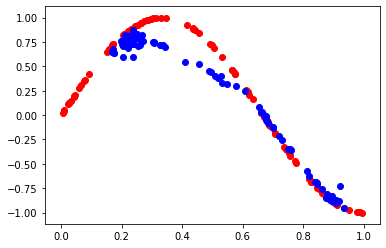

Epoch:4899   Acc_real:0.410000   Acc_fake:0.340000


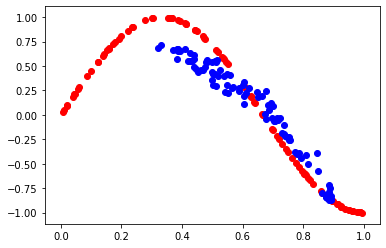

Epoch:4999   Acc_real:0.680000   Acc_fake:0.260000


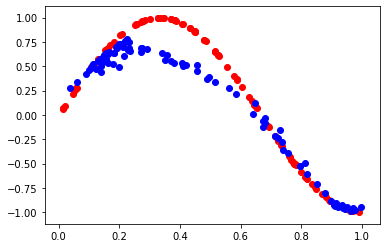

Epoch:5099   Acc_real:0.420000   Acc_fake:0.690000


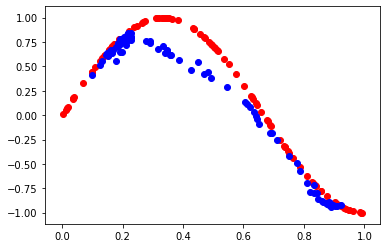

Epoch:5199   Acc_real:0.560000   Acc_fake:0.500000


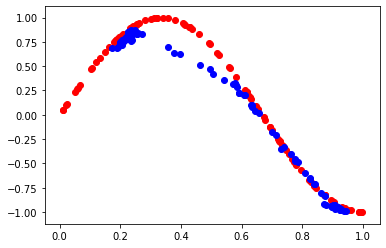

Epoch:5299   Acc_real:0.420000   Acc_fake:0.680000


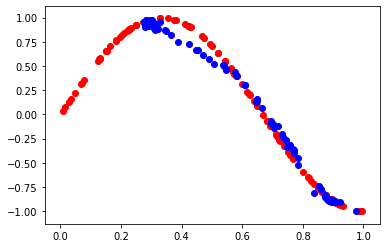

Epoch:5399   Acc_real:0.550000   Acc_fake:0.400000


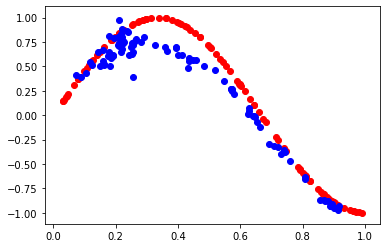

Epoch:5499   Acc_real:0.660000   Acc_fake:0.380000


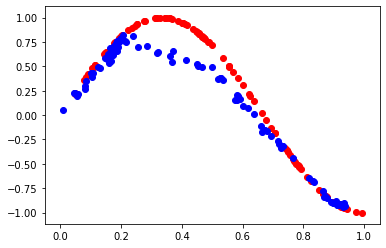

Epoch:5599   Acc_real:0.370000   Acc_fake:0.710000


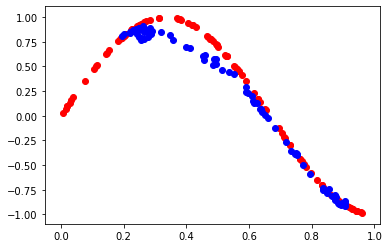

Epoch:5699   Acc_real:0.800000   Acc_fake:0.210000


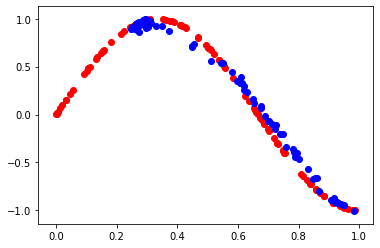

Epoch:5799   Acc_real:0.930000   Acc_fake:0.030000


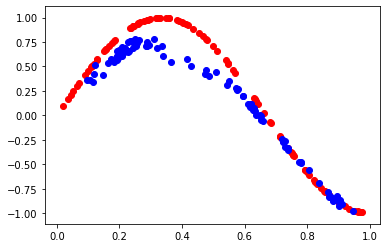

Epoch:5899   Acc_real:0.560000   Acc_fake:0.640000


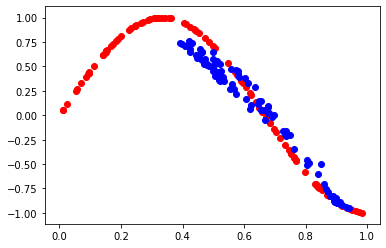

Epoch:5999   Acc_real:0.660000   Acc_fake:0.320000


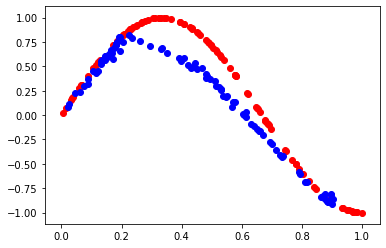

Epoch:6099   Acc_real:0.510000   Acc_fake:0.680000


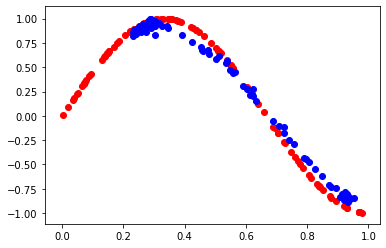

Epoch:6199   Acc_real:0.730000   Acc_fake:0.460000


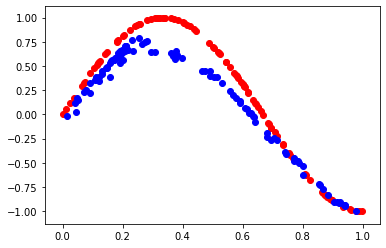

Epoch:6299   Acc_real:0.950000   Acc_fake:0.440000


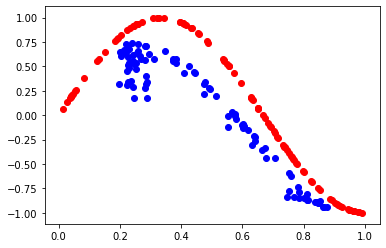

Epoch:6399   Acc_real:0.390000   Acc_fake:0.700000


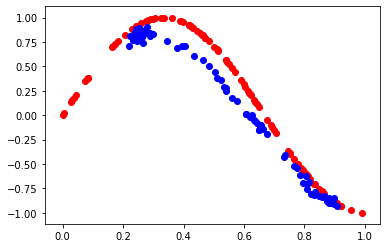

Epoch:6499   Acc_real:0.800000   Acc_fake:0.200000


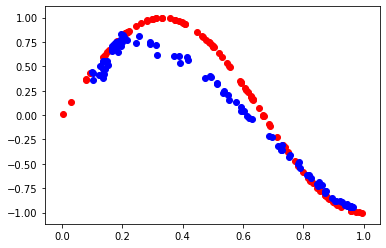

Epoch:6599   Acc_real:0.650000   Acc_fake:0.160000


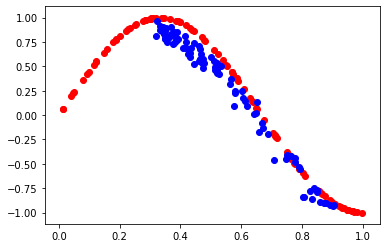

Epoch:6699   Acc_real:0.410000   Acc_fake:0.690000


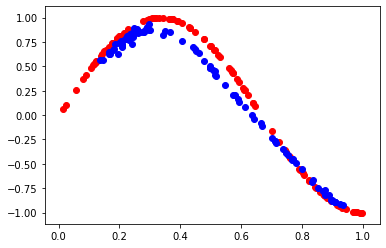

Epoch:6799   Acc_real:0.890000   Acc_fake:0.180000


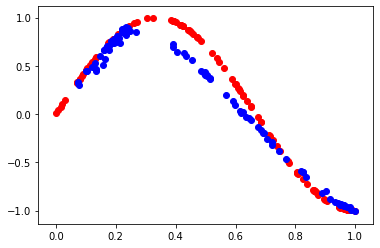

Epoch:6899   Acc_real:0.670000   Acc_fake:0.960000


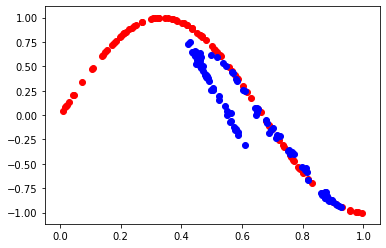

Epoch:6999   Acc_real:0.470000   Acc_fake:0.760000


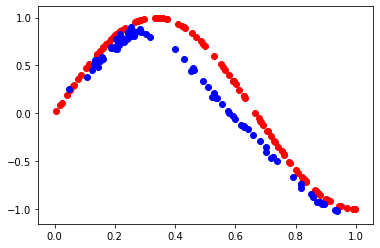

Epoch:7099   Acc_real:0.860000   Acc_fake:0.200000


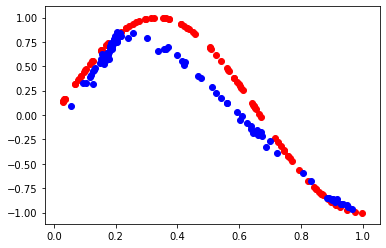

Epoch:7199   Acc_real:0.290000   Acc_fake:0.750000


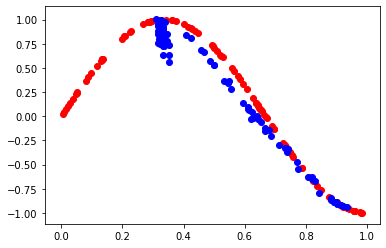

Epoch:7299   Acc_real:0.410000   Acc_fake:0.660000


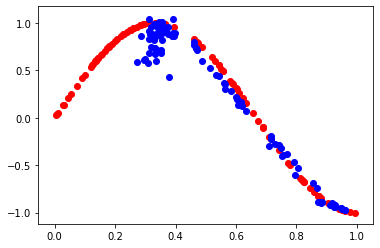

Epoch:7399   Acc_real:0.570000   Acc_fake:0.660000


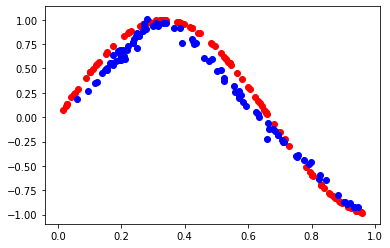

Epoch:7499   Acc_real:0.750000   Acc_fake:0.640000


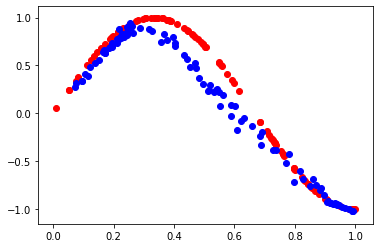

Epoch:7599   Acc_real:0.720000   Acc_fake:0.600000


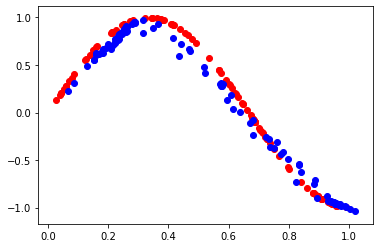

Epoch:7699   Acc_real:0.460000   Acc_fake:0.580000


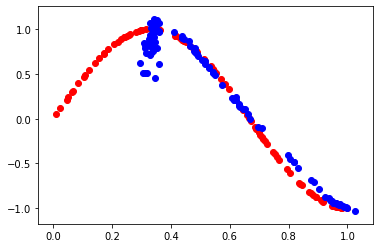

Epoch:7799   Acc_real:0.790000   Acc_fake:0.390000


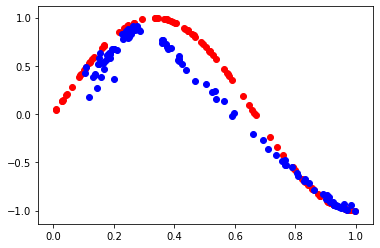

Epoch:7899   Acc_real:0.760000   Acc_fake:0.410000


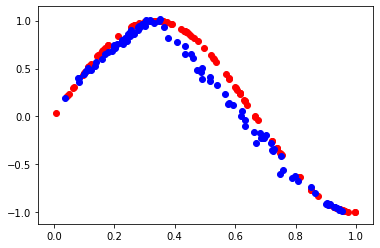

Epoch:7999   Acc_real:0.590000   Acc_fake:0.580000


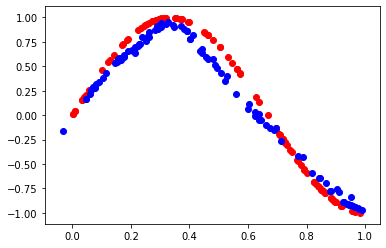

Epoch:8099   Acc_real:0.790000   Acc_fake:0.430000


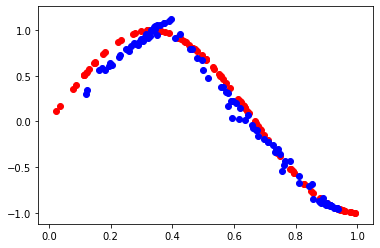

Epoch:8199   Acc_real:0.270000   Acc_fake:0.680000


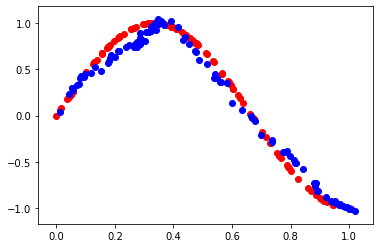

Epoch:8299   Acc_real:0.540000   Acc_fake:0.590000


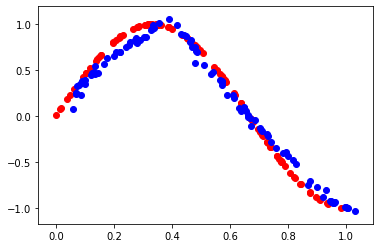

Epoch:8399   Acc_real:0.780000   Acc_fake:0.330000


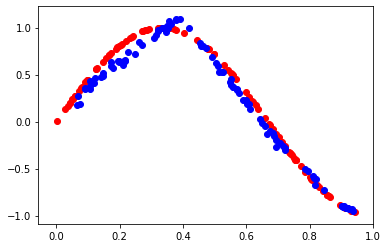

Epoch:8499   Acc_real:0.760000   Acc_fake:0.310000


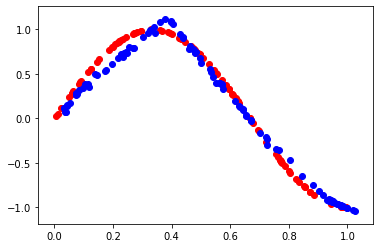

Epoch:8599   Acc_real:0.720000   Acc_fake:0.280000


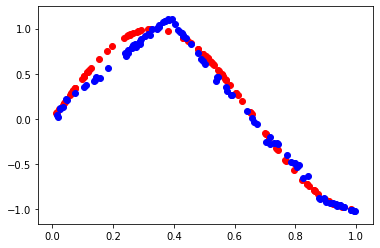

Epoch:8699   Acc_real:0.720000   Acc_fake:0.370000


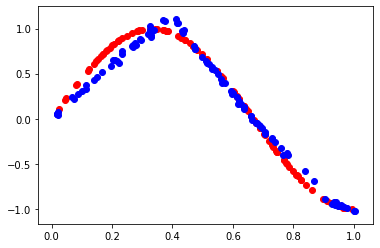

Epoch:8799   Acc_real:0.700000   Acc_fake:0.560000


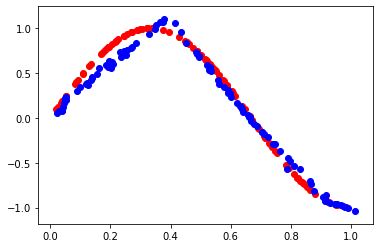

Epoch:8899   Acc_real:0.580000   Acc_fake:0.720000


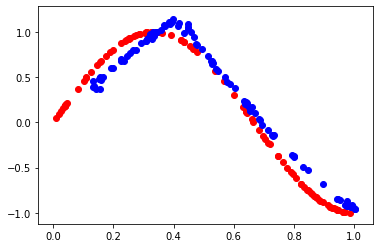

Epoch:8999   Acc_real:0.370000   Acc_fake:0.730000


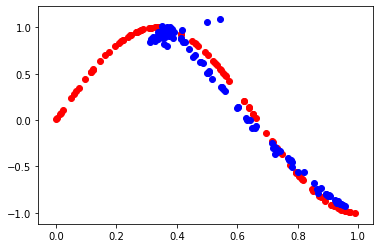

Epoch:9099   Acc_real:0.080000   Acc_fake:1.000000


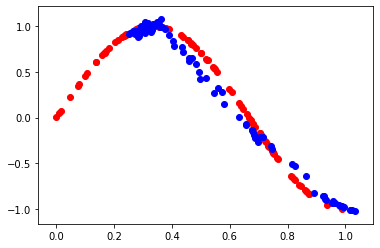

Epoch:9199   Acc_real:0.170000   Acc_fake:0.890000


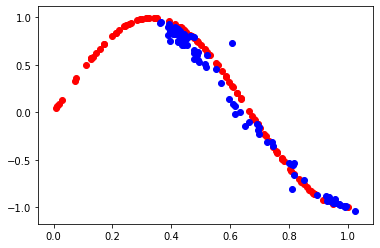

Epoch:9299   Acc_real:0.670000   Acc_fake:0.290000


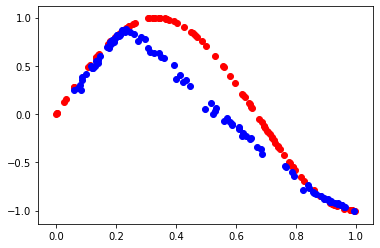

Epoch:9399   Acc_real:0.750000   Acc_fake:0.180000


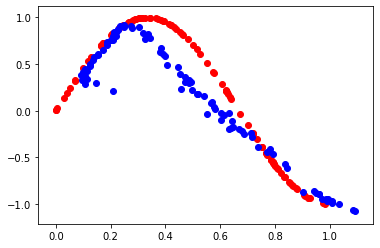

Epoch:9499   Acc_real:0.710000   Acc_fake:0.680000


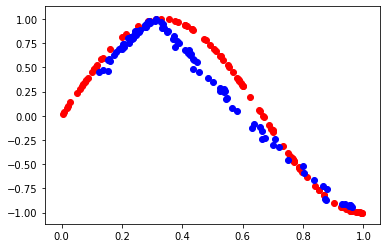

Epoch:9599   Acc_real:0.640000   Acc_fake:0.520000


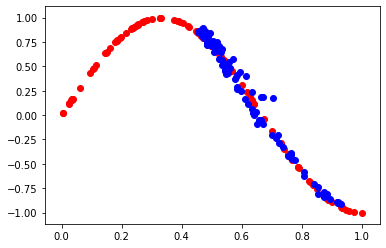

Epoch:9699   Acc_real:0.630000   Acc_fake:0.280000


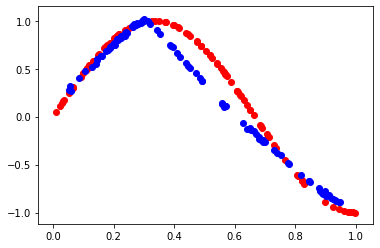

Epoch:9799   Acc_real:0.360000   Acc_fake:0.670000


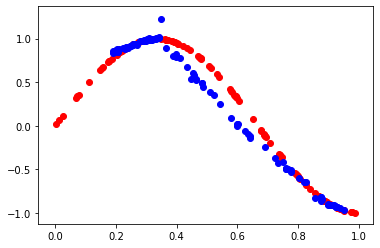

Epoch:9899   Acc_real:0.500000   Acc_fake:0.780000


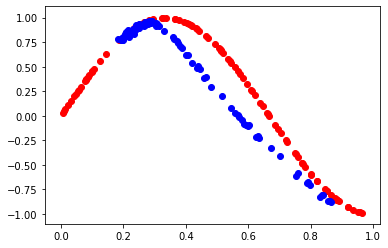

Epoch:9999   Acc_real:0.590000   Acc_fake:0.710000


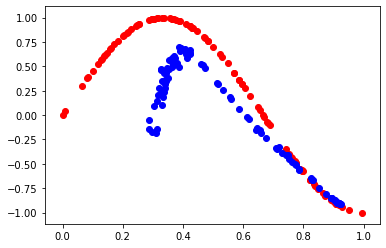

CPU times: user 19min 31s, sys: 1min 23s, total: 20min 54s
Wall time: 18min 5s


In [0]:
%%time
# size of the latent space
latent_dim = 12
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator) # 여기서 define해주고, 실제 트레인에 들어간다.

# train model: override=True -> 같은 위치에 plot
train(generator, discriminator, gan_model, latent_dim, override=False) # 위에서 정의된 트레인 펑션이 실제로 진행됨.


In [0]:
gan_model.save('/content/drive/Shared drives/scsa_2019_a/9_smc/model_simple_gan_191212.hdf5')
gan_model.save_weights('/content/drive/Shared drives/scsa_2019_a/9_smc/model_simple_gan_191212.h5')

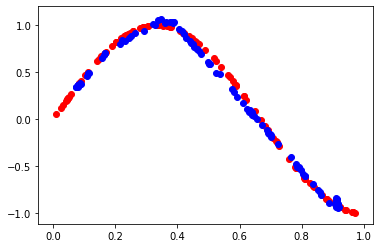

In [0]:
test_model = tf.keras.models.load_model('/content/drive/Shared drives/scsa_2019_e/models/model_simple_gan_191211.hdf5')

In [0]:
test_model.get_config()

{'layers': [{'class_name': 'Sequential',
   'config': {'batch_input_shape': (None, 5),
    'layers': [{'class_name': 'Dense',
      'config': {'activation': 'relu',
       'activity_regularizer': None,
       'batch_input_shape': (None, 5),
       'bias_constraint': None,
       'bias_initializer': {'class_name': 'Zeros', 'config': {}},
       'bias_regularizer': None,
       'dtype': 'float32',
       'kernel_constraint': None,
       'kernel_initializer': {'class_name': 'VarianceScaling',
        'config': {'distribution': 'uniform',
         'mode': 'fan_in',
         'scale': 2.0,
         'seed': None}},
       'kernel_regularizer': None,
       'name': 'dense_14',
       'trainable': True,
       'units': 15,
       'use_bias': True}},
     {'class_name': 'Dense',
      'config': {'activation': 'linear',
       'activity_regularizer': None,
       'bias_constraint': None,
       'bias_initializer': {'class_name': 'Zeros', 'config': {}},
       'bias_regularizer': None,
       'dt

## **실습 과제**

### 과제1

- #### 결과가 만족스러운가? 더 개선할 수 있을까? (GAN 모델은 학습이 쉽지 않음)
- #### Latent space vector를 늘리면? latent_dim = ??
- #### 학습에 사용되는 batch size를 늘리면? n=batch = ??
- #### D 모델 학습을 한번 더 시키면? 





Latent space vector를 늘린다고 해도 썩 좋은 결과를 보이는 것은 아니었다. 12까지 늘려봤을 때 역시 그때 그때 괜찮은 값이 나오는 것처럼 보였지만, 결국 반복적으로 돌릴 때 큰 차이가 없다는 사실을 확인할 수 있었다.

초기의 값까지는 어느정도 유의미한 차이가 있어보인다. generator가 만든 fake data들이 real data와 유사한 형태로 더 빨리 비슷해지는 것처럼 보이는 것이다. 

그러나 이는 금방 흐트러지는데, 이는 학습이 어려운 Simple GAN에서 현재 주어진 사인 그래프란 과제는 난이도가 높은 과제이기 때문에 학습을 진행하여도 어느정도 이상은 유의미한 결과를 얻는데 한계가 있는 것이다.

batch_size를 늘린 것도 마찬가지로, 마치 유사한 값을 찾아가는 것처럼 보였지만, 여전히 반복적으로 돌릴 때는 큰 차이가 없다는 것을 알 수 있다.

### 과제2

D 모델의 학습 횟수를 늘리면 D모델이 판단을 더 잘하니까 진짠지 가짠지 더 잘 파악할 수 있고, 그렇기 때문에 결과적으로 generator가 더 좋은 결과를 뽑아낼 수 있을 것으로 보인다. 

다만 유의해야할 점은 지나치게 d모델을 학습시킬 경우에는 d모델과 g모델간에 model collapsing이 일어나 학습이 되지 않을 수 있기 때문에 적정 선을 잘 파악하여 수행해야할 것이다.